# 4-panel figure for trend variability

Calculate the variability of trends in sea ice concentration, surface temperature, ASR, and OLR from the CESM1-LE.

I've already done this in cems1le_forcedresponse.ipynb but want to show variability for trends 2001-2021 AND trends 2001-2050. This will motivate the later question about how changing variability impacts climate signal emergence.

__Also this would be great with Dask but it doesn't seem to be working....__

### Do imports

In [3]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, gridspec, ccrs, 
    Iterable, cmaps, glob, copy
    )

from functions import (
    masked_average, add_weights, leap_year,
    to_png, stats, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [4]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [5]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [6]:
def vectorized_linregress_arb(data,dim):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
        
    regressed_month = xr.apply_ufunc(
        linregress2, data[dim], data,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

### Iterate over ensemble members and variables of interest

In [7]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [8]:
model_variables = ['ICEFRAC','FLUT','FSNTOA','TS','LANDFRAC','TMQ']


In [9]:
# hardcoded alternate with only ensembles we can use
ensemble_nums2 = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Collect all paths in a dictionary

In [10]:
path_dict = {} # first key is the ensemble number, second is the model variable

for _ensn in ensemble_nums2:
    for _var in model_variables:
        _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
        _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

        if (len(_t1_file) != 1) or (len(_t2_file) != 1):
            print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
            break
        try:
            path_dict[_ensn][_var]=[*_t1_file,*_t2_file]
        except:
            path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

In [11]:
def calc_spatial_trends(data_paths,var,tsel,zonal=False):
    
    data = xr.open_mfdataset(data_paths,chunks={'time': -1})[var] # chunking doesn't seem to work here
    data = data.sel(time=tsel)
    
    if zonal: # zonal averages speed things up >100x
        data = data.mean(dim='lon')
    
    trends_monthly = data.chunk({'time': -1}).groupby('time.month').map(vectorized_linregress_arb_wrap,dim='time')
    
    annual_data = data.groupby('time.year').mean('time').chunk({'year':-1})
    trends_annual = vectorized_linregress_arb(annual_data,dim='year') # don't need the wrapper function here
                                
    trends_all = xr.concat([trends_monthly,trends_annual.assign_coords({'month':13}).expand_dims('month',axis=-1)],dim='month')
    
    trends_all['parameter'] = ["slope","intercept","r_value","p_value","std_err",]
    
    # clean up!!!
    # data_path.close()
    del data_paths,data,annual_data,trends_monthly,trends_annual
                            
    return trends_all
    # return trends_monthly,trends_annual

In [12]:
def vectorized_linregress_arb_wrap(data,dim):
    '''
    Dumb wrapper function to solve a dumb problem.
    '''
    
    # the regression needs year, but this step needs to happen after the groupby...
    data['time'] = data['time.year']
    
    return vectorized_linregress_arb(data,dim)

In [13]:
outpath = '/glade/work/jonahshaw/LENS/CESM1-LE/GlobalSpatialTrends/'

In [14]:
def save_spatial_trends(trends,save_dir,var_str,ens_str,timeperiod_str):
    
    final_trends = trends.compute()
    final_trends.name = var_str
    
    final_trends.to_netcdf('%s/%s.%s.%s.nc' % (save_dir,var_str,ens_str,timeperiod_str))
    
    del trends,final_trends

#### Test the code

In [15]:
ex_paths = path_dict['001']['TS']

In [16]:
%%time

sample_trend = calc_spatial_trends(ex_paths,var='TS',tsel=slice('2001-01-01','2080-12-31'))

CPU times: user 256 ms, sys: 17.5 ms, total: 274 ms
Wall time: 575 ms


In [17]:
%%time

test_avg = sample_trend.compute()

CPU times: user 2min 35s, sys: 455 ms, total: 2min 35s
Wall time: 2min 41s


In [31]:
%%time

save_spatial_trends(sample_trend,save_dir=outpath,var_str='TS',ens_str='001',timeperiod_str='2001_2080')

CPU times: user 2min 23s, sys: 300 ms, total: 2min 24s
Wall time: 2min 28s


In [34]:
test_open = xr.open_dataarray('%s/%s.%s.%s.nc' % (outpath,'TS','001','2001_2080'))

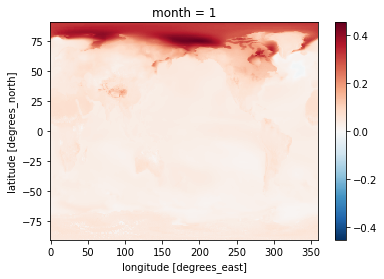

In [37]:
test_open.sel(parameter=0,month=1).plot()

#### Apply the code

Trends 2001-2050 (an appropriate length for the detection of slower months).

The full global spatial trends are slow (~2.5 minutes per member per field).

In [43]:
# outpath_global = '/glade/work/jonahshaw/LENS/CESM1-LE/GlobalSpatialTrends/'

# for _ens in path_dict:
#     print(_ens)
    
#     for _var in path_dict[_ens]:
#         print(_var,end=' ')
        
#         paths = path_dict[_ens][_var]
        
#         sample_trend = calc_spatial_trends(paths,var=_var,tsel=slice('2001-01-01','2050-12-31'))
        
#         save_spatial_trends(sample_trend,save_dir=outpath,var_str=_var,ens_str=_ens,timeperiod_str='2001_2050')
    
#     break

001
ICEFRAC FLUT FSNTOA TS LANDFRAC TMQ 

Computing zonal trends is much easier. Just takes a few minutes.

In [18]:
%%time

outpath_zonal = '/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/'

for _ens in path_dict:
    print(_ens)
    
    for _var in path_dict[_ens]:
        if _var != 'LANDFRAC':
            print(_var,end=' ')

            paths = path_dict[_ens][_var]

            sample_trend = calc_spatial_trends(paths,var=_var,tsel=slice('2001-01-01','2021-12-31'),zonal=True)

            save_spatial_trends(sample_trend,save_dir=outpath_zonal,var_str=_var,ens_str=_ens,timeperiod_str='2001_2021')
            
            # break

001
ICEFRAC FLUT FSNTOA TS TMQ 002
ICEFRAC FLUT FSNTOA TS TMQ 003
ICEFRAC FLUT FSNTOA TS TMQ 004
ICEFRAC FLUT FSNTOA TS TMQ 005
ICEFRAC FLUT FSNTOA TS TMQ 006
ICEFRAC FLUT FSNTOA TS TMQ 007
ICEFRAC FLUT FSNTOA TS TMQ 008
ICEFRAC FLUT FSNTOA TS TMQ 009
ICEFRAC FLUT FSNTOA TS TMQ 010
ICEFRAC FLUT FSNTOA TS TMQ 011
ICEFRAC FLUT FSNTOA TS TMQ 012
ICEFRAC FLUT FSNTOA TS TMQ 013
ICEFRAC FLUT FSNTOA TS TMQ 014
ICEFRAC FLUT FSNTOA TS TMQ 015
ICEFRAC FLUT FSNTOA TS TMQ 016
ICEFRAC FLUT FSNTOA TS TMQ 017
ICEFRAC FLUT FSNTOA TS TMQ 018
ICEFRAC FLUT FSNTOA TS TMQ 019
ICEFRAC FLUT FSNTOA TS TMQ 020
ICEFRAC FLUT FSNTOA TS TMQ 021
ICEFRAC FLUT FSNTOA TS TMQ 022
ICEFRAC FLUT FSNTOA TS TMQ 023
ICEFRAC FLUT FSNTOA TS TMQ 024
ICEFRAC FLUT FSNTOA TS TMQ 025
ICEFRAC FLUT FSNTOA TS TMQ 026
ICEFRAC FLUT FSNTOA TS TMQ 027
ICEFRAC FLUT FSNTOA TS TMQ 028
ICEFRAC FLUT FSNTOA TS TMQ 029
ICEFRAC FLUT FSNTOA TS TMQ 030
ICEFRAC FLUT FSNTOA TS TMQ 031
ICEFRAC FLUT FSNTOA TS TMQ 032
ICEFRAC FLUT FSNTOA TS TMQ 033
ICEF

### Plot variability

In [19]:
panel_variables = ['ICEFRAC', 'FLUT', 'FSNTOA', 'TS', 'TMQ']
zonalavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/'

In [125]:
multiens_dict = {}

for _var in panel_variables:
    
    all_ens = [] # list to combine later
    
    for _ensn in ensemble_nums2:            
        _file = glob.glob('%s/*%s.%s*2050.nc' % (zonalavg_path,_var,_ensn))[0]
        _ds = xr.open_dataset(_file)
        
        _ds2 = _ds.assign_coords({'ensn':int(_ensn)}).expand_dims('ensn')
        _ds.close()
        
        if _ensn == '001': # handle a weird combining error by interpolating Toronto runs to standard grid
            _interptarget = _ds
        
        # add
        if _ensn in ['101','102','103','104','105',]: 
            _ds2 = _ds2.interp_like(_interptarget)
        
        all_ens.append(_ds2)
        
    combined = xr.combine_by_coords(all_ens)
    multiens_dict[_var] = combined
    
all_2001_2050_trends_ds = xr.merge(list(multiens_dict.values()))    

In [21]:
multiens_dict = {}

for _var in panel_variables:
    
    all_ens = [] # list to combine later
    
    for _ensn in ensemble_nums2:            
        _file = glob.glob('%s/*%s.%s*2001_2021.nc' % (zonalavg_path,_var,_ensn))[0]
        _ds = xr.open_dataset(_file)
        
        _ds2 = _ds.assign_coords({'ensn':int(_ensn)}).expand_dims('ensn')
        _ds.close()
        
        if _ensn == '001': # handle a weird combining error by interpolating Toronto runs to standard grid
            _interptarget = _ds
        
        # add
        if _ensn in ['101','102','103','104','105',]: 
            _ds2 = _ds2.interp_like(_interptarget)
        
        all_ens.append(_ds2)
        
    combined = xr.combine_by_coords(all_ens)
    multiens_dict[_var] = combined
    
all_2001_2021_trends_ds = xr.merge(list(multiens_dict.values()))    

2001-2050

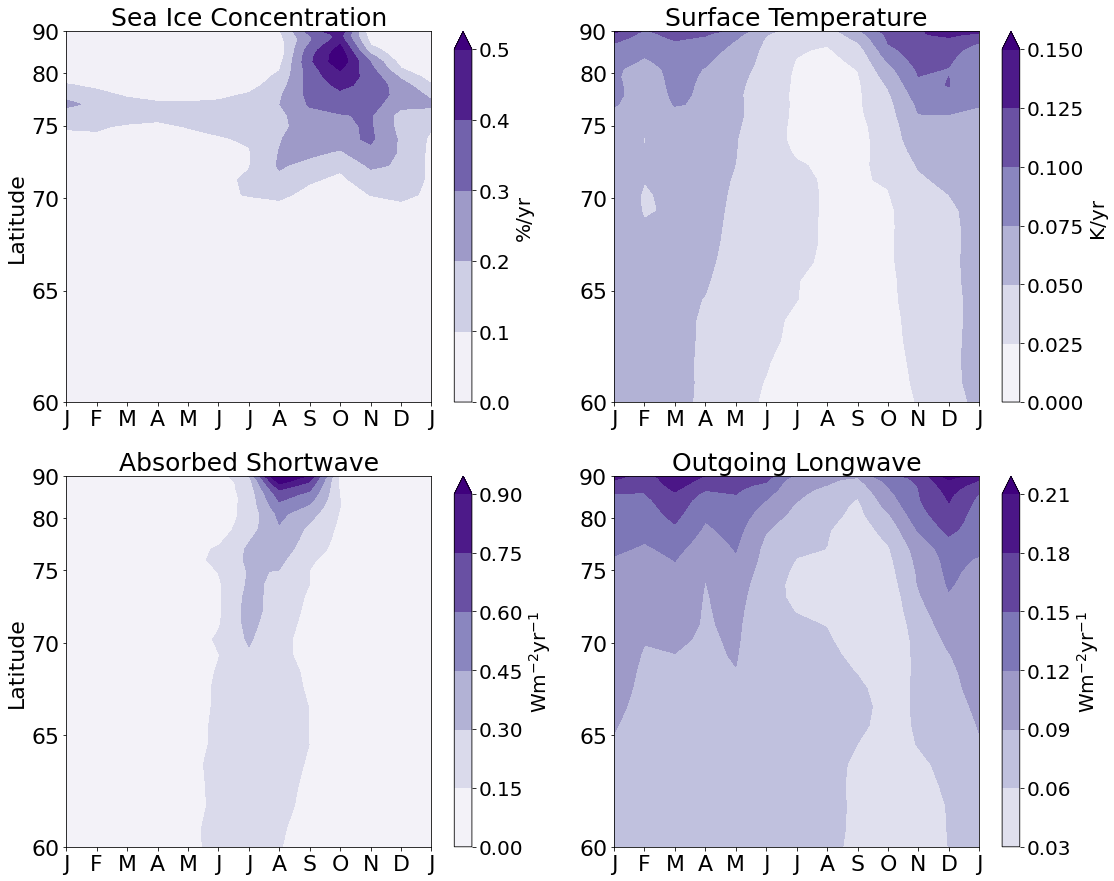

In [28]:
all_2001_2021_trends_monthsonly = all_2001_2021_trends_ds.sel(month=slice(1,12)) # remove the annual value

_olr2     = all_2001_2021_trends_monthsonly['FLUT'].sel(parameter='slope').std(dim='ensn')
_asr2     = all_2001_2021_trends_monthsonly['FSNTOA'].sel(parameter='slope').std(dim='ensn')
_icefrac2 = 100*all_2001_2021_trends_monthsonly['ICEFRAC'].sel(parameter='slope').std(dim='ensn')
_ts2      = all_2001_2021_trends_monthsonly['TS'].sel(parameter='slope').std(dim='ensn')

olr_trends_wrapped    = xr.concat([_olr2,_olr2[0].assign_coords({'month':13})],dim='month')
asr_trends_wrapped    = xr.concat([_asr2,_asr2[0].assign_coords({'month':13})],dim='month')
seaice_trends_wrapped = xr.concat([_icefrac2,_icefrac2[0].assign_coords({'month':13})],dim='month')
ts_trends_wrapped     = xr.concat([_ts2,_ts2[0].assign_coords({'month':13})],dim='month')

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
fig1.subplots_adjust(wspace=0.2,hspace=0.2)

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)
    
axes[0].set_ylabel('Latitude',fontsize=22)
axes[2].set_ylabel('Latitude',fontsize=22)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,0.51,0.1))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')

axes[0].set_title('Sea Ice Concentration',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='%/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,0.16,0.025))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')

axes[1].set_title('Surface Temperature',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='K/yr',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,1.01,0.15))#,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')

axes[2].set_title('Absorbed Shortwave',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.03,0.211,0.03))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')

axes[3].set_title('Outgoing Longwave',fontsize=25)
cbar3 = plt.colorbar(im3,ax=axes[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

# fig1.suptitle('Trend Standard Deviation (2001-2021)',fontsize=27,y=0.95)

In [29]:
to_png(file=fig1,filename='fig_lensvariability_4panel_2001_2021',dpi=300,ext='pdf',bbox_inches='tight')

2001-2050

Text(0.5, 0.95, 'Trend Standard Deviation (2001-2050)')

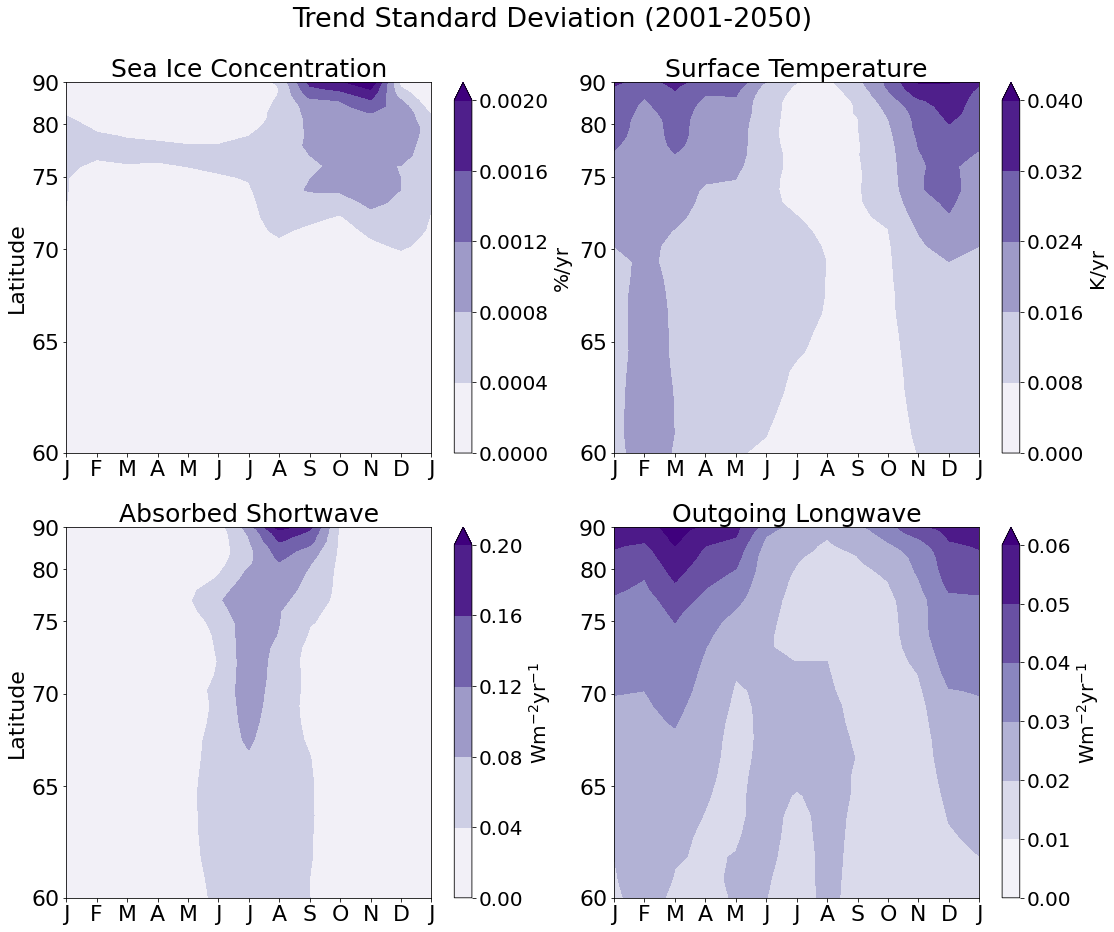

In [121]:
all_2001_2050_trends_monthsonly = all_2001_2050_trends_ds.sel(month=slice(1,12)) # remove the annual value

_olr2 = all_2001_2050_trends_monthsonly['FLUT'].sel(parameter='slope').std(dim='ensn')
_asr2 = all_2001_2050_trends_monthsonly['FSNTOA'].sel(parameter='slope').std(dim='ensn')
_icefrac2 = all_2001_2050_trends_monthsonly['ICEFRAC'].sel(parameter='slope').std(dim='ensn')
_ts2 = all_2001_2050_trends_monthsonly['TS'].sel(parameter='slope').std(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2,_ts2[0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2,_icefrac2[0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2,_asr2[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2,_olr2[0].assign_coords({'month':13})],dim='month')


palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
fig1.subplots_adjust(wspace=0.2,hspace=0.2)

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)
    
axes[0].set_ylabel('Latitude',fontsize=22)
axes[2].set_ylabel('Latitude',fontsize=22)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,0.0021,0.0004))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')

axes[0].set_title('Sea Ice Concentration',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='%/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,0.041,0.008))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')

axes[1].set_title('Surface Temperature',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='K/yr',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,0.21,0.04))#,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')

axes[2].set_title('Absorbed Shortwave',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,0.061,0.01))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')

axes[3].set_title('Outgoing Longwave',fontsize=25)
cbar3 = plt.colorbar(im3,ax=axes[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('Trend Standard Deviation (2001-2050)',fontsize=27,y=0.95)

2021-2041

Text(0.5, 0.95, 'Trend Standard Deviation (2021-2041)')

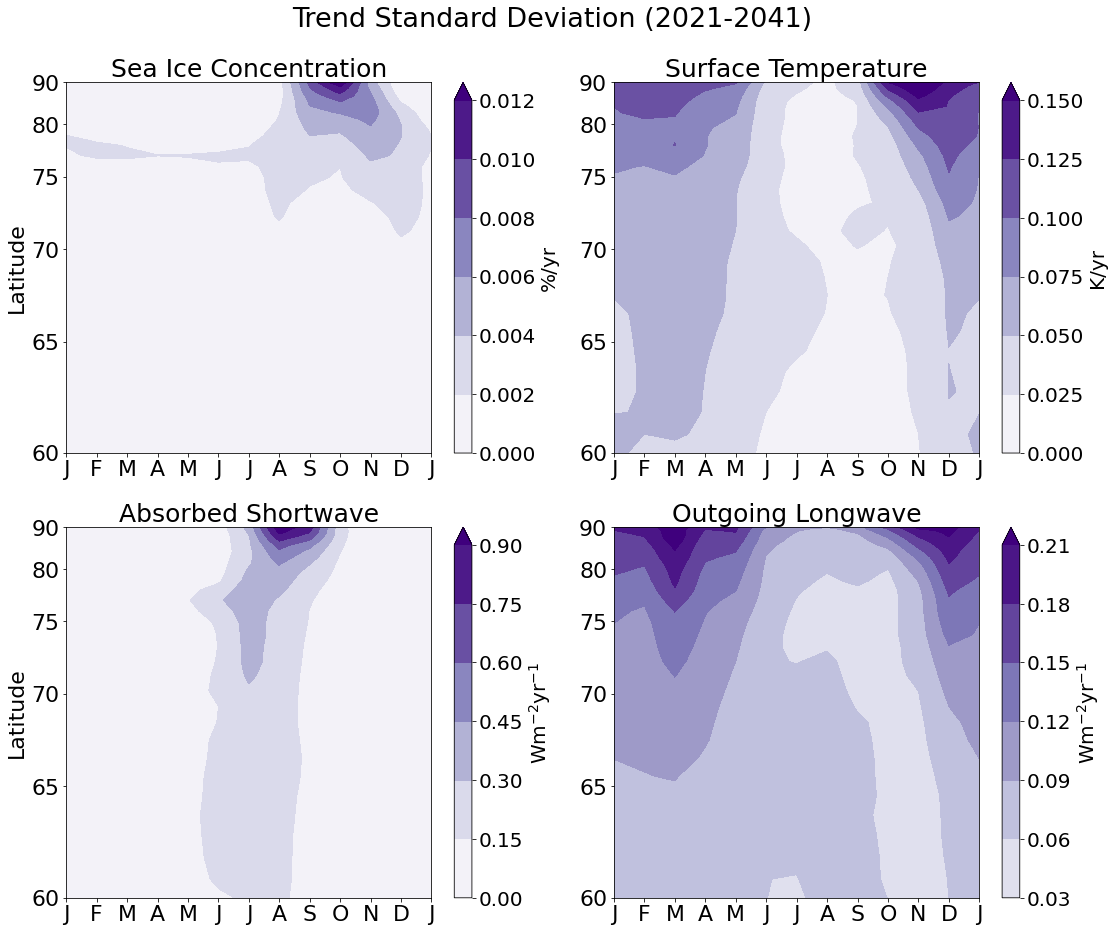

In [130]:
all_2021_2041_trends_monthsonly = all_2021_2041_trends_ds.sel(month=slice(1,12)) # remove the annual value

_olr2 = all_2021_2041_trends_monthsonly['FLUT'].sel(parameter='slope').std(dim='ensn')
_asr2 = all_2021_2041_trends_monthsonly['FSNTOA'].sel(parameter='slope').std(dim='ensn')
_icefrac2 = all_2021_2041_trends_monthsonly['ICEFRAC'].sel(parameter='slope').std(dim='ensn')
_ts2 = all_2021_2041_trends_monthsonly['TS'].sel(parameter='slope').std(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2,_ts2[0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2,_icefrac2[0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2,_asr2[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2,_olr2[0].assign_coords({'month':13})],dim='month')


palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
fig1.subplots_adjust(wspace=0.2,hspace=0.2)

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)
    
axes[0].set_ylabel('Latitude',fontsize=22)
axes[2].set_ylabel('Latitude',fontsize=22)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap='Purples',vmin=0,extend='max')#,levels=np.arange(0.0,0.51,0.1))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')

axes[0].set_title('Sea Ice Concentration',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='%/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,0.16,0.025))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')

axes[1].set_title('Surface Temperature',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='K/yr',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.0,1.01,0.15))#,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')

axes[2].set_title('Absorbed Shortwave',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap='Purples',vmin=0,extend='max',levels=np.arange(0.03,0.211,0.03))#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')

axes[3].set_title('Outgoing Longwave',fontsize=25)
cbar3 = plt.colorbar(im3,ax=axes[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('Trend Standard Deviation (2021-2041)',fontsize=27,y=0.95)